In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from joblib import Memory

In [2]:
# configure cache
cachedir = ".cache"
memory = Memory(cachedir, verbose=0)

In [3]:
@memory.cache
def get_poly(path):
  return requests.get(path).text

In [4]:
@memory.cache
def scrape(url, path=[]):
  shapes = []
  # get the web page
  response = requests.get(url+'/'.join(path) + ('/' if len(path) > 0 else ''))
  response.raise_for_status()  # Raise an exception for bad status codes

  # Parse the HTML content
  soup = BeautifulSoup(response.content, 'html.parser')

  # Extract data (e.g., all links)
  for link in soup.find_all('a'):
    href = link.get('href')
    if href[0] == '?' or href[0] == '/':
      continue
    elif href[(-len('.poly')):] == '.poly':
      region = href.replace('.poly', '')
      shapes.append(('/'.join(path+[region]), get_poly(url+'/'.join(path+[href]))))
    elif href[-1] == '/':
      shapes += scrape(url, path+[href[:-1]])
  return shapes

In [5]:
# Fetch the website content
base_url = 'https://download.openstreetmap.fr/polygons/'
shapes = scrape(base_url)

In [6]:
shapes = pd.DataFrame(shapes, columns=['name', 'polygon'])
shapes.info()
shapes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345 entries, 0 to 1344
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   name     1345 non-null   object
 1   polygon  1345 non-null   object
dtypes: object(2)
memory usage: 21.1+ KB


,name,polygon
0,africa,africa\nafrica\n 11.600920 33.998750\n 1...
1,africa/algeria,polygon\n1\n\t-8.710000000000001\t28.31\n\t-8....
2,africa/angola,polygon\n1\n\t11.5\t-17.25\n\t11.51\t-16.95\n\...
3,africa/benin,polygon\n1\n\t0.755\t10.38\n\t0.765\t10.535\n\...
4,africa/bir_tawil,polygon\n1\n\t34.081\t22.004\n\t34.083\t22.003...
...,...,...
1340,south-america/guyane,polygon\n1\n\t-54.62\t2.315\n\t-54.625\t2.325\...
1341,south-america/paraguay,polygon\n1\n\t-62.665\t-22.255\n\t-62.665\t-22...
1342,south-america/south_georgia_and_south_sandwich,polygon\n1\n\t-42.39\t-53.59\n\t-42.4\t-53.52\...
1343,south-america/suriname,polygon\n1\n\t-58.09\t4.175\n\t-58.075\t4.195\...


In [7]:
shapes.to_csv('data/global-polygons.csv', lineterminator='\n\n')

In [8]:
from shapely import Point, Polygon, MultiPolygon, union_all
import re
from functools import reduce

In [9]:
class PolygonBuilder():
  def __init__(self):
    self.__points = []
  def with_point(self, lon, lat):
    self.__points.append(Point(lon, lat))
    return self
  def build(self):
    return Polygon(self.__points)

class MultipolygonBuilder():
  def __init__(self):
    self.__polygons = []
  def with_polygon(self, polygon):
    self.__polygons.append(polygon)
    return self
  def build(self):
    return MultiPolygon(self.__polygons)


In [10]:
shapes.polygon.apply(lambda poly: type(poly))

0       <class 'str'>
1       <class 'str'>
2       <class 'str'>
3       <class 'str'>
4       <class 'str'>
            ...      
1340    <class 'str'>
1341    <class 'str'>
1342    <class 'str'>
1343    <class 'str'>
1344    <class 'str'>
Name: polygon, Length: 1345, dtype: object

In [11]:
point_pattern = re.compile(r'([0-9.E+-]+)\s+([0-9.E+-]+)')

def to_point(s):
  m = point_pattern.match(s)
  if m is None:
    return s
  return Point(m.group(1), m.group(2))

def to_poly(collectors, item):
  if type(item) == str:
    if item == 'END':
      collector = collectors.pop()
      if isinstance(collector, PolygonBuilder):
        collectors[-1].with_polygon(collector.build())
      else:
        return collector.build()
    else:
      if item[0] == '!':
        print('hole item', item)
        #TODO handle holes
      collectors.append(MultipolygonBuilder() if len(collectors) == 0 else PolygonBuilder())
  elif isinstance(item, Point):
    collectors[-1].with_point(*(item.x, item.y))
  else:
    raise TypeError(f'unsupported type: {type(item)}')
  return collectors



def to_shape(poly_str):
  step_1 = map(lambda l: l.strip(), poly_str.split('\n'))
  step_2 = filter(lambda l: len(l) > 0, step_1)
  step_3 = map(to_point, step_2)
  step_4 = reduce(to_poly, step_3, [])
  return step_4

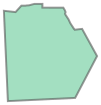

In [12]:
africa = shapes[shapes.name == 'africa'].polygon.values[0]
to_shape(africa)

In [13]:
shapes['geometry'] = shapes.polygon.apply(to_shape)
shapes

hole item !2
hole item !2
hole item !3
hole item !4
hole item !5
hole item !6
hole item !10
hole item !2
hole item !2
hole item !3
hole item !2
hole item !3
hole item !4
hole item !5
hole item !2
hole item !2
hole item !2
hole item !2
hole item !2
hole item !2
hole item !3
hole item !4
hole item !5
hole item !2
hole item !2
hole item !3
hole item !2
hole item !2
hole item !2
hole item !2
hole item !2
hole item !2
hole item !2
hole item !3
hole item !2
hole item !3
hole item !2
hole item !2
hole item !2
hole item !2
hole item !2
hole item !2
hole item !3
hole item !4
hole item !5
hole item !2
hole item !2
hole item !2
hole item !3
hole item !4
hole item !2
hole item !2
hole item !2
hole item !3
hole item !2
hole item !3
hole item !4
hole item !2
hole item !2
hole item !3
hole item !4
hole item !2
hole item !2
hole item !2
hole item !2
hole item !2
hole item !2
hole item !3
hole item !2
hole item !2
hole item !2
hole item !2
hole item !2
hole item !2
hole item !2
hole item !2
hole item !

,name,polygon,geometry
0,africa,africa\nafrica\n 11.600920 33.998750\n 1...,"MULTIPOLYGON (((11.60092 33.99875, 11.60207 37..."
1,africa/algeria,polygon\n1\n\t-8.710000000000001\t28.31\n\t-8....,"MULTIPOLYGON (((-8.71 28.31, -8.71 28.68, -8.7..."
2,africa/angola,polygon\n1\n\t11.5\t-17.25\n\t11.51\t-16.95\n\...,"MULTIPOLYGON (((11.5 -17.25, 11.51 -16.95, 11...."
3,africa/benin,polygon\n1\n\t0.755\t10.38\n\t0.765\t10.535\n\...,"MULTIPOLYGON (((0.755 10.38, 0.765 10.535, 0.7..."
4,africa/bir_tawil,polygon\n1\n\t34.081\t22.004\n\t34.083\t22.003...,"MULTIPOLYGON (((34.081 22.004, 34.083 22.003, ..."
...,...,...,...
1340,south-america/guyane,polygon\n1\n\t-54.62\t2.315\n\t-54.625\t2.325\...,"MULTIPOLYGON (((-54.62 2.315, -54.625 2.325, -..."
1341,south-america/paraguay,polygon\n1\n\t-62.665\t-22.255\n\t-62.665\t-22...,"MULTIPOLYGON (((-62.665 -22.255, -62.665 -22.2..."
1342,south-america/south_georgia_and_south_sandwich,polygon\n1\n\t-42.39\t-53.59\n\t-42.4\t-53.52\...,"MULTIPOLYGON (((-42.39 -53.59, -42.4 -53.52, -..."
1343,south-america/suriname,polygon\n1\n\t-58.09\t4.175\n\t-58.075\t4.195\...,"MULTIPOLYGON (((-58.09 4.175, -58.075 4.195, -..."


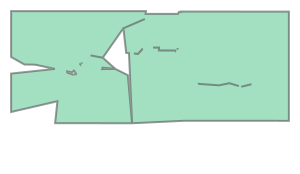

In [14]:
import geopandas as gpd

union_all(gpd.GeoDataFrame(shapes, geometry='geometry').geometry)
